# TVS Loan Default Prediction

A reproducible end-to-end notebook that compares gradient-boosted trees and several neural-network architectures for classifying loan defaults.[1]

In [1]:
# Installation (first run only)
%pip install --quiet optuna==3.6.1 xgboost==2.0.3 imbalanced-learn==0.12.2 scikit-learn==1.4.2 seaborn==0.13.2 pandas==2.2.2 tensorflow==2.16.1 joblib==1.5.1


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Download and Load Data

In [4]:
import os, json, zipfile, warnings, random, joblib
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, precision_recall_curve, roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
warnings.filterwarnings('ignore')

# Load CSV directly from same folder
df = pd.read_csv('./TVS.csv')

# Define new column names
new_columns = [
    "Customer_ID",
    "First_EMI_Bounced",
    "Bounces_Last_12_Months",
    "Max_MOB",
    "Total_Bounces_On_Loan",
    "EMI",
    "Loan_Amount",
    "Tenure",
    "Dealer_Code",
    "Product_Code",
    "Advance_EMIs_Paid",
    "Interest_Rate",
    "Gender",
    "Employment_Type",
    "Resident_Type",
    "DOB",
    "Loan_Age_At_Application",
    "Total_Loans",
    "Secured_Loans",
    "Unsecured_Loans",
    "Max_Sanctioned_Amount_Live",
    "New_Loans_Last_3_Months",
    "Total_Secured_Sanctioned_Live",
    "Total_Unsecured_Sanctioned_Live",
    "Max_TwoWheeler_Loan_Amount",
    "Months_Since_Last_Personal_Loan",
    "Months_Since_First_Consumer_Durable_Loan",
    "DPD_30_Last_6_Months",
    "DPD_60_Last_6_Months",
    "DPD_90_Last_3_Months",
    "Tier",
    "Loan_Default"
]

# Rename columns
df.columns = new_columns
# Drop rows with missing values 
df.dropna(inplace=True)

# Preview the data
df.head()


,Customer_ID,First_EMI_Bounced,Bounces_Last_12_Months,Max_MOB,Total_Bounces_On_Loan,EMI,Loan_Amount,Tenure,Dealer_Code,Product_Code,...,Total_Secured_Sanctioned_Live,Total_Unsecured_Sanctioned_Live,Max_TwoWheeler_Loan_Amount,Months_Since_Last_Personal_Loan,Months_Since_First_Consumer_Durable_Loan,DPD_30_Last_6_Months,DPD_60_Last_6_Months,DPD_90_Last_3_Months,Tier,Loan_Default
89,90,0,3,33.0,4.0,1448.0,37900.0,36.0,1244.0,SC,...,109250.0,317800.0,37900.0,125.0,40.0,5,5,2,TIER 3,1
94,95,0,0,33.0,0.0,1734.0,43850.0,36.0,1487.0,MC,...,2266305.0,153979.0,43850.0,31.0,55.0,24,24,12,TIER 1,1
144,145,0,0,32.0,0.0,1775.0,44500.0,36.0,1496.0,SC,...,835690.0,46250.0,44500.0,37.0,48.0,5,3,1,TIER 1,0
147,148,0,0,31.0,0.0,1588.0,45000.0,36.0,3273.0,SC,...,300000.0,124000.0,45000.0,23.0,26.0,0,0,0,TIER 1,0
155,156,0,1,32.0,2.0,1867.0,46100.0,36.0,1519.0,MC,...,3904932.0,212756.0,46100.0,26.0,32.0,43,31,13,TIER 2,0


### 2. Exploratory Data Analysis

(1672, 32)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Customer_ID,1672.0,NaN,NaN,NaN,45248.73445,25137.582027,90.0,23346.75,47633.5,67631.0,85032.0
First_EMI_Bounced,1672.0,NaN,NaN,NaN,0.034689,0.183046,0.0,0.0,0.0,0.0,1.0
Bounces_Last_12_Months,1672.0,NaN,NaN,NaN,0.311603,0.664864,0.0,0.0,0.0,0.0,5.0
Max_MOB,1672.0,NaN,NaN,NaN,17.837321,5.575431,6.0,13.75,18.0,21.0,36.0
Total_Bounces_On_Loan,1672.0,NaN,NaN,NaN,0.516746,0.901336,0.0,0.0,0.0,1.0,5.0


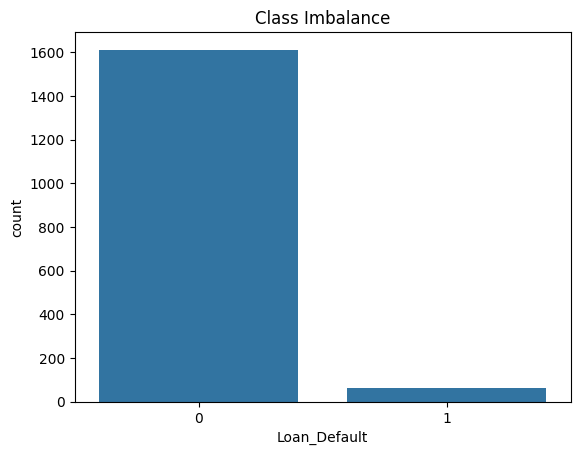

In [6]:
print(df.shape)
display(df.describe(include='all').T.head())

sns.countplot(x='Loan_Default', data=df)
plt.title('Class Imbalance')
plt.show()

## 3. Pre-processing Pipeline

In [8]:
target = 'Loan_Default'
y = df[target]
X = df.drop(columns=[target])

num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(exclude='number').columns.tolist()

num_tf = Pipeline([('scaler', StandardScaler())])
cat_tf = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([
    ('num', num_tf, num_cols),
    ('cat', cat_tf, cat_cols)
])


## 4. Baseline Model – XGBoost

In [9]:
import xgboost as xgb
from imblearn.metrics import classification_report_imbalanced

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
)

model_xgb = ImbPipeline([
    ('pre', preprocess),
    ('sm', SMOTE(random_state=42)),
    ('clf', xgb_clf)
])

model_xgb.fit(X_train, y_train)
proba = model_xgb.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print('ROC-AUC:', roc_auc_score(y_test, proba))
print('PR-AUC:', average_precision_score(y_test, proba))
print(classification_report_imbalanced(y_test, pred))

ROC-AUC: 0.8015995872033024
PR-AUC: 0.18270208584784312
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.98      0.08      0.97      0.29      0.09       323
          1       0.12      0.08      0.98      0.10      0.29      0.07        12

avg / total       0.94      0.95      0.12      0.94      0.29      0.09       335



## 5. Hyper-parameter Tuning for XGBoost (Optuna)

In [10]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        **params
    )
    pipe = ImbPipeline([('pre', preprocess), ('sm', SMOTE(random_state=42)), ('clf', clf)])
    auc = cross_val_score(pipe, X_train, y_train, scoring='roc_auc', cv=3).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25, show_progress_bar=False)
best_params = study.best_params
best_params

[I 2025-06-27 16:51:36,049] A new study created in memory with name: no-name-369b7cff-7958-4e65-a0aa-c9be8cb674aa
[I 2025-06-27 16:51:37,993] Trial 0 finished with value: 0.7559820024936302 and parameters: {'n_estimators': 214, 'max_depth': 7, 'learning_rate': 0.012789164140968128, 'subsample': 0.7904924523991537, 'colsample_bytree': 0.626755107769609}. Best is trial 0 with value: 0.7559820024936302.
[I 2025-06-27 16:51:39,228] Trial 1 finished with value: 0.7067783153538967 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.2429604340041548, 'subsample': 0.7278311415208345, 'colsample_bytree': 0.7085255241740276}. Best is trial 0 with value: 0.7559820024936302.
[I 2025-06-27 16:51:44,737] Trial 2 finished with value: 0.7351787101787103 and parameters: {'n_estimators': 575, 'max_depth': 10, 'learning_rate': 0.029313900689343263, 'subsample': 0.8255560379708098, 'colsample_bytree': 0.7758917901847019}. Best is trial 0 with value: 0.7559820024936302.
[I 2025-06-27 1

{'n_estimators': 775,
 'max_depth': 3,
 'learning_rate': 0.010632567427253038,
 'subsample': 0.6018375610756155,
 'colsample_bytree': 0.9978703594472027}

## 6. Neural-Network Architectures

In [11]:
from tensorflow.keras import layers, models, optimizers, callbacks

# Prepare numeric matrix after preprocessing
X_prep = preprocess.fit_transform(X)
input_dim = X_prep.shape[1]

def make_mlp(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['AUC'])
    return model

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_prep, y, stratify=y, test_size=0.2, random_state=42)

mlp = make_mlp(input_dim)
early = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
hist = mlp.fit(X_train_p, y_train_p, validation_split=0.2, epochs=50, batch_size=256, callbacks=[early], verbose=0)
nn_proba = mlp.predict(X_test_p).ravel()
print('MLP ROC-AUC:', roc_auc_score(y_test_p, nn_proba))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MLP ROC-AUC: 0.6235810113519091


In [12]:
# 1-D CNN (treat feature vector as sequence)
def make_cnn(input_dim):
    model = models.Sequential([
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        layers.Conv1D(32, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

cnn = make_cnn(input_dim)
early = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
cnn.fit(X_train_p, y_train_p, validation_split=0.2, epochs=50, batch_size=256, callbacks=[early], verbose=0)
cnn_proba = cnn.predict(X_test_p).ravel()
print('CNN ROC-AUC:', roc_auc_score(y_test_p, cnn_proba))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
CNN ROC-AUC: 0.6519607843137254


In [15]:
import numpy as np
import time
from tensorflow.keras import models, layers, callbacks

# Ensure float32 dtype (TensorFlow runs faster this way)
X_train_p = X_train_p.astype(np.float32)
X_test_p = X_test_p.astype(np.float32)
y_train_p = y_train_p.astype(np.float32)
y_test_p = y_test_p.astype(np.float32)

input_dim = X_train_p.shape[1]

# ⏱️ Timer callback
class TimeLogger(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start = time.time()
    def on_train_end(self, logs=None):
        print("⏱️ Training Time: {:.2f}s".format(time.time() - self.start))

# ⚡️ Lightweight LSTM
def make_fast_lstm(input_dim):
    model = models.Sequential([
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),  # reshape to (timesteps, features)
        layers.LSTM(32, dropout=0.2, recurrent_dropout=0.1),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

# 🚀 Train
lstm = make_fast_lstm(input_dim)
early = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
timer = TimeLogger()

history = lstm.fit(
    X_train_p, y_train_p,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early, timer],
    verbose=1
)

# 🎯 Predict & Evaluate
lstm_proba = lstm.predict(X_test_p).ravel()
print('✅ LSTM ROC-AUC:', roc_auc_score(y_test_p, lstm_proba))


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 889ms/step - AUC: 0.5499 - loss: 0.6832 - val_AUC: 0.3857 - val_loss: 0.6514
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 809ms/step - AUC: 0.4542 - loss: 0.6380 - val_AUC: 0.3857 - val_loss: 0.5917
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 819ms/step - AUC: 0.4147 - loss: 0.5638 - val_AUC: 0.3876 - val_loss: 0.4273
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 862ms/step - AUC: 0.4638 - loss: 0.3579 - val_AUC: 0.5000 - val_loss: 0.1679
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 773ms/step - AUC: 0.5621 - loss: 0.1754 - val_AUC: 0.4570 - val_loss: 0.1618
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 794ms/step - AUC: 0.4833 - loss: 0.1803 - val_AUC: 0.5000 - val_loss: 0.1664
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 797ms/step - AUC: 0.4406 - loss: 0.1840 - val_AUC: 0.5019 - val_loss: 0.1646
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 837ms/step - AUC: 0.4680 - loss: 0.1600 - val_AUC: 0.6163 - val_loss: 0.1614
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 820ms/step - AUC: 0.5148 - loss:

## 7. Business-Weighted Cost Metric

In [16]:
def business_score(y_true, y_pred, fp_cost=5):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tp - fp_cost * fp

models_scores = {
    'XGBoost': business_score(y_test, pred),
    'MLP': business_score(y_test_p, (nn_proba>=0.5).astype(int)),
    'CNN': business_score(y_test_p, (cnn_proba>=0.5).astype(int)),
    'LSTM': business_score(y_test_p, (lstm_proba>=0.5).astype(int))
}
models_scores

{'XGBoost': -34, 'MLP': 0, 'CNN': 0, 'LSTM': 0}

## 8. Persist Best Model

In [18]:
best_name = max(models_scores, key=models_scores.get)
if best_name == 'XGBoost':
    joblib.dump(model_xgb, 'best_model_xgb.joblib')
else:
    ml_models = {'MLP': mlp, 'CNN': cnn, 'LSTM': lstm}
    ml_models[best_name].save('best_nn_model.keras')  # no warning
print('Saved', best_name)

Saved MLP
